In [2]:
### IMPORTS ###

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import wrds
from sklearn.linear_model import LinearRegression

In [3]:
db = wrds.Connection(wrds_username="rorapetri")

Loading library list...
Done


In [4]:
#Stocks Database
stocknames = db.get_table(library='crsp', table='stocknames')

In [5]:
#Get Stock Data by Ticker
ticker = "COKE"
stocknames[stocknames['ticker'] == ticker]

,permno,permco,namedt,nameenddt,cusip,ncusip,ticker,comnam,hexcd,exchcd,siccd,shrcd,shrcls,st_date,end_date,namedum
3985,11995.0,1035.0,1982-11-01,2019-01-01,19109810,19109810,COKE,COCA COLA BOTTLING CO CONS,3.0,3.0,2080.0,11.0,None,1982-11-30,2020-12-31,2.0
3986,11995.0,1035.0,2019-01-02,2020-12-31,19109810,19109810,COKE,COCA COLA CONSOLIDATED INC,3.0,3.0,2086.0,11.0,None,1982-11-30,2020-12-31,2.0


In [6]:
#Set Date Limits
date_begins = "'2011-08-31'"
date_ends = "'2020-08-31'"

#Select Permco
permco = 1035

#Get Daily Stock Returns for the given Time Period
stock = db.raw_sql("""
                    select permco, date, ret
                    from crsp.dsf
                    where permco = {}
                    and date>= {}
                    and date<= {}
                    """.format(permco, date_begins, date_ends))
                    #index_col=['date']#

stock


,permco,date,ret
0,1035.0,2011-08-31,-0.007972
1,1035.0,2011-09-01,0.007679
2,1035.0,2011-09-02,-0.025164
3,1035.0,2011-09-06,-0.008544
4,1035.0,2011-09-07,0.013568
...,...,...,...
2260,1035.0,2020-08-25,-0.010344
2261,1035.0,2020-08-26,-0.002731
2262,1035.0,2020-08-27,0.005003
2263,1035.0,2020-08-28,0.011918


In [7]:
#Retrieving data from FF in WRDS
ff = db.get_table(library='ff',table='factors_daily')
ff = ff[['date','mktrf','smb','hml']]

#Select Date Period
ff = ff[(ff['date'].astype('str') >= date_begins[1:-1]) & (ff['date'].astype('str') <= date_ends[1:-1])]

#Format Date Column and Add Year, Month, Day Columns
ff['date'] = pd.to_datetime(ff['date'])
ff['year'] = ff['date'].dt.year
ff['month'] = ff['date'].dt.month
ff['day'] = ff['date'].dt.day

ff = ff.set_index(ff['date'])
ff = ff.drop(['date'], axis = 1)
ff

,mktrf,smb,hml,year,month,day
date,,,,,,
2011-08-31,0.0042,-0.0081,0.0049,2011,8,31
2011-09-01,-0.0133,-0.0106,-0.0079,2011,9,1
2011-09-02,-0.0264,-0.0076,-0.0075,2011,9,2
2011-09-06,-0.0072,0.0051,-0.0065,2011,9,6
2011-09-07,0.0306,0.0089,0.0103,2011,9,7
...,...,...,...,...,...,...
2020-08-25,0.0036,0.0014,-0.0063,2020,8,25
2020-08-26,0.0100,-0.0115,-0.0176,2020,8,26
2020-08-27,0.0018,-0.0034,0.0099,2020,8,27


In [8]:
#Combing ret Column of Stock with Fama French Factors
data = ff.reset_index(drop=True)
data['ret'] = stock['ret']
data

,mktrf,smb,hml,year,month,day,ret
0,0.0042,-0.0081,0.0049,2011,8,31,-0.007972
1,-0.0133,-0.0106,-0.0079,2011,9,1,0.007679
2,-0.0264,-0.0076,-0.0075,2011,9,2,-0.025164
3,-0.0072,0.0051,-0.0065,2011,9,6,-0.008544
4,0.0306,0.0089,0.0103,2011,9,7,0.013568
...,...,...,...,...,...,...,...
2260,0.0036,0.0014,-0.0063,2020,8,25,-0.010344
2261,0.0100,-0.0115,-0.0176,2020,8,26,-0.002731
2262,0.0018,-0.0034,0.0099,2020,8,27,0.005003
2263,0.0070,0.0029,-0.0024,2020,8,28,0.011918


In [9]:
#MultiIndex by Date (Year/Month)
outside = data['year']
inside = data['month']
inside2 = data['day']
hier_index = list(zip(outside,inside, inside2))
hier_index = pd.MultiIndex.from_tuples(hier_index)
data = data.set_index(hier_index)
data.index.names = ['Year','Month', 'Day']
data = data[['mktrf', 'smb', 'hml', 'ret', 'year', 'month', 'day']]
data.drop(['year','month','day'], axis = 1, inplace=True)
data

mktrf     smb     hml       ret
Year Month Day                                  
2011 8     31   0.0042 -0.0081  0.0049 -0.007972
     9     1   -0.0133 -0.0106 -0.0079  0.007679
           2   -0.0264 -0.0076 -0.0075 -0.025164
           6   -0.0072  0.0051 -0.0065 -0.008544
           7    0.0306  0.0089  0.0103  0.013568
...                ...     ...     ...       ...
2020 8     25   0.0036  0.0014 -0.0063 -0.010344
           26   0.0100 -0.0115 -0.0176 -0.002731
           27   0.0018 -0.0034  0.0099  0.005003
           28   0.0070  0.0029 -0.0024  0.011918
           31  -0.0004 -0.0045 -0.0175 -0.018636

[2265 rows x 4 columns]

In [50]:
#Monthly Beta Data Frame
end_date = datetime.datetime(data.index.max()[0], data.loc[data.index.max()[0]].index.max()[0],1)
start_date = datetime.datetime(data.index.min()[0], data.loc[data.index.min()[0]].index.min()[0], 1)
num_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month) + 1

monthly_betas = pd.DataFrame(np.zeros((num_months, 7)), columns=['date', 'year','month','day','mktrf beta','smb beta','hml beta'])
count = 0
    
for i in range(data.index.min()[0], data.index.max()[0]+1):
    for j in range(data.loc[i].index.min()[0], data.loc[i].index.max()[0]+1):
        aux = data.loc[i].loc[j]
        X = aux[['mktrf','smb','hml']]
        Y = aux[['ret']]
        regr = LinearRegression()
        regr.fit(X,Y)
        monthly_betas['year'][count] = i
        monthly_betas['month'][count] = j
        monthly_betas['day'][count] = 1
        monthly_betas.loc[[count], ['mktrf beta','smb beta','hml beta']] = regr.coef_
        count = count + 1


for i in range(0, len(monthly_betas)):
    monthly_betas['date'][i] = datetime.datetime(monthly_betas['year'][i].astype('int'), monthly_betas['month'][i].astype('int'),1).strftime("%Y-%m")

monthly_betas = monthly_betas.set_index(monthly_betas['date'])
monthly_betas = monthly_betas.drop(['date','year','month','day'], axis = 1)

monthly_betas


,mktrf beta,smb beta,hml beta
date,,,
2011-08,0.000000,0.000000,0.000000
2011-09,-0.082098,0.082598,0.989075
2011-10,0.959153,0.234981,0.742612
2011-11,0.458779,1.774909,0.320930
2011-12,0.123076,1.588501,0.939259
...,...,...,...
2020-04,1.054372,-0.087762,0.648065
2020-05,0.369092,0.665466,0.388741
2020-06,0.932337,0.514058,0.101639


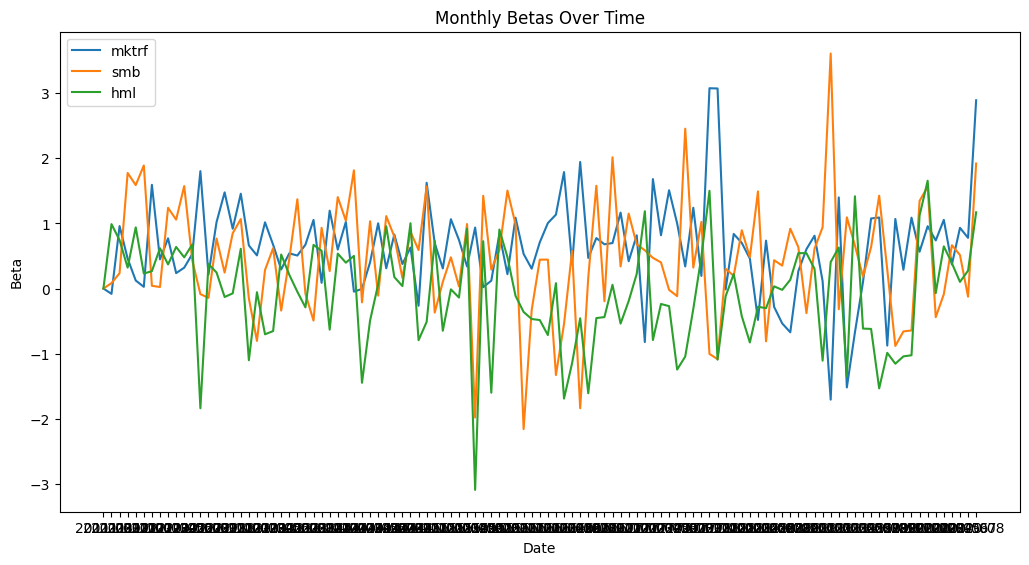

In [11]:
#Monthly Betas Plot
#Create Figure (empty canvas)
fig = plt.figure(figsize=(12,6), dpi=100)

# Add set of axes to figure
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(monthly_betas)
axes.set_xlabel('Date')
axes.set_ylabel('Beta')
axes.set_title('Monthly Betas Over Time')

plt.legend(['mktrf', 'smb', 'hml'])


In [91]:
#Monthly Beta Changes (%)
delta_monthly = monthly_betas

delta_mktrf = np.zeros(len(monthly_betas))
delta_smb = np.zeros(len(monthly_betas))
delta_hml = np.zeros(len(monthly_betas))

for i in range(2, len(monthly_betas)-1):
    delta_mktrf[i] = ((monthly_betas['mktrf beta'][i]-monthly_betas['mktrf beta'][i-1])/monthly_betas['mktrf beta'][i-1])*100
    delta_smb[i] = ((monthly_betas['smb beta'][i]-monthly_betas['smb beta'][i-1])/monthly_betas['smb beta'][i-1])*100
    delta_hml[i] = ((monthly_betas['hml beta'][i]-monthly_betas['hml beta'][i-1])/monthly_betas['hml beta'][i-1])*100

delta_monthly['mktrf delta'] = delta_mktrf
delta_monthly['smb delta'] = delta_smb
delta_monthly['hml delta'] = delta_hml


In [259]:
delta_monthly

,mktrf beta,smb beta,hml beta,mktrf delta,smb delta,hml delta
date,,,,,,
2011-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-09,-0.082098,0.082598,0.989075,0.000000,0.000000,0.000000
2011-10,0.959153,0.234981,0.742612,-1268.299579,184.488945,-24.918590
2011-11,0.458779,1.774909,0.320930,-52.168288,655.341945,-56.783556
2011-12,0.123076,1.588501,0.939259,-73.173258,-10.502418,192.667487
...,...,...,...,...,...,...
2020-04,1.054372,-0.087762,0.648065,42.796163,-80.082403,-1016.329852
2020-05,0.369092,0.665466,0.388741,-64.994159,-858.259157,-40.015177
2020-06,0.932337,0.514058,0.101639,152.603060,-22.752208,-73.854355


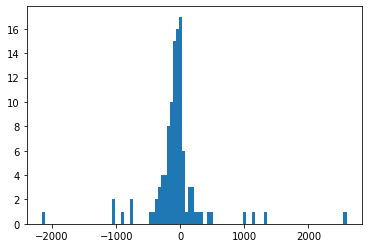

In [265]:
plt.hist(delta_monthly['hml delta'], bins=100);

In [253]:
#Separate Outliers by Threshold
sigma = 2.5 #deviations from the mean 
q_mkrtf = delta_monthly['mktrf delta'].quantile(.99)
q_smb = delta_monthly['smb delta'].quantile(.99)
q_hml = delta_monthly['hml delta'].quantile(.99)

#Set Threshold with Mean and StDev without outliers (99% Quantile)
threshold_mkrtf = abs(delta_monthly[(abs(delta_monthly['mktrf delta']) <= q_mkrtf)]['mktrf delta']).mean() + sigma*abs(delta_monthly[(abs(delta_monthly['mktrf delta']) <= q_mkrtf)]['mktrf delta']).std()
threshold_smb = abs(delta_monthly[(abs(delta_monthly['smb delta']) <= q_smb)]['smb delta']).mean() + sigma*abs(delta_monthly[(abs(delta_monthly['smb delta']) <= q_smb)]['smb delta']).std()
threshold_hml = abs(delta_monthly[(abs(delta_monthly['hml delta']) <= q_hml)]['hml delta']).mean() + sigma*abs(delta_monthly[(abs(delta_monthly['hml delta']) <= q_hml)]['hml delta']).std()

change_mkrtf = delta_monthly[(abs(delta_monthly['mktrf delta']) >= threshold_mkrtf)]
change_smb = delta_monthly[(abs(delta_monthly['smb delta']) >= threshold_smb)]
change_hml = delta_monthly[(abs(delta_monthly['hml delta']) >= threshold_hml)]

In [254]:
#Number of 'Outlier' Observations For Each Beta Change
[len(change_mkrtf),len(change_smb), len(change_hml)] 

[9, 5, 8]

In [256]:
#Concatenate the Three Dataframes Into One
outliers = pd.concat([change_mkrtf,change_smb,change_hml])
outliers

,mktrf beta,smb beta,hml beta,mktrf delta,smb delta,hml delta
date,,,,,,
2011-10,0.959153,0.234981,0.742612,-1268.299579,184.488945,-24.918590
2012-02,1.592567,0.041873,0.266871,6044.119537,-97.784418,16.167713
2013-12,1.195478,0.267660,-0.631941,1269.372394,-71.279287,-208.977109
2014-05,0.402542,1.033100,-0.491057,-7112.412877,-584.642967,-66.084599
2014-12,1.624210,1.568047,-0.512281,-712.765099,165.072476,-35.461341
2017-11,3.076197,-1.004693,1.500519,1488.296559,-198.231016,204.430915
2018-02,0.838299,0.193646,0.223361,-6010.604562,-36.250825,-289.391492
2019-02,-1.706824,3.609070,0.406326,-1603.162286,283.574205,-136.664879
2019-07,1.076090,0.635529,-0.620550,942.970708,250.041279,0.833203


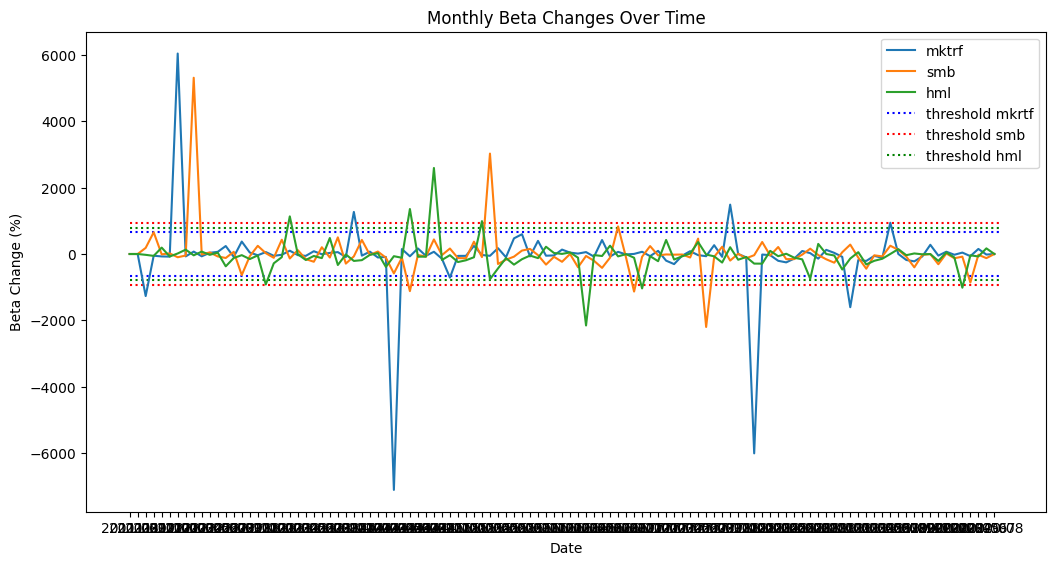

In [257]:
#Monthly Beta Changes Line Plot
#Create Figure (empty canvas)
fig = plt.figure(figsize=(12,6), dpi=100)

# Add set of axes to figure
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(delta_monthly['mktrf delta'])
axes.plot(delta_monthly['smb delta'])
axes.plot(delta_monthly['hml delta'])

axes.hlines(y=threshold_mkrtf, xmin=0, xmax=109, colors='blue', linestyles='dotted')
axes.hlines(y=threshold_smb, xmin=0, xmax=109, colors='red', linestyles='dotted')
axes.hlines(y=threshold_hml, xmin=0, xmax=109, colors='green', linestyles='dotted')

axes.hlines(y=-threshold_mkrtf, xmin=0, xmax=109, colors='blue', linestyles='dotted')
axes.hlines(y=-threshold_smb, xmin=0, xmax=109, colors='red', linestyles='dotted')
axes.hlines(y=-threshold_hml, xmin=0, xmax=109, colors='green', linestyles='dotted')

axes.set_xlabel('Date')
axes.set_ylabel('Beta Change (%)')
axes.set_title('Monthly Beta Changes Over Time')

plt.legend(['mktrf', 'smb', 'hml', 'threshold mkrtf', 'threshold smb', 'threshold hml'])

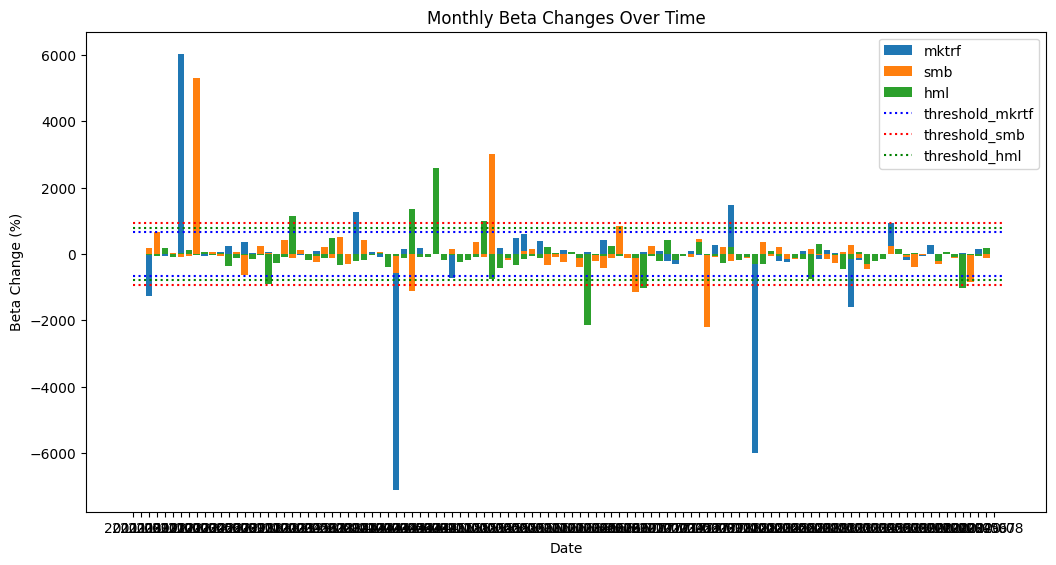

In [258]:
#Monthly Beta Changes Bar Plot
#Create Figure (empty canvas)
fig = plt.figure(figsize=(12,6), dpi=100)

# Add set of axes to figure
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
b1 = axes.bar(x=delta_monthly.index, height=delta_monthly['mktrf delta'])
b2 = axes.bar(x=delta_monthly.index, height=delta_monthly['smb delta'])
b3 = axes.bar(x=delta_monthly.index, height=delta_monthly['hml delta'])

h1 = axes.hlines(y=threshold_mkrtf, xmin=0, xmax=109, colors='blue', linestyles='dotted')
axes.hlines(y=-threshold_mkrtf, xmin=0, xmax=109, colors='blue', linestyles='dotted')

h2 = axes.hlines(y=threshold_smb, xmin=0, xmax=109, colors='red', linestyles='dotted')
axes.hlines(y=-threshold_smb, xmin=0, xmax=109, colors='red', linestyles='dotted')

h3 = axes.hlines(y=threshold_hml, xmin=0, xmax=109, colors='green', linestyles='dotted')
axes.hlines(y=-threshold_hml, xmin=0, xmax=109, colors='green', linestyles='dotted')

axes.set_xlabel('Date')
axes.set_ylabel('Beta Change (%)')
axes.set_title('Monthly Beta Changes Over Time')

plt.legend([b1,b2,b3,h1,h2,h3],['mktrf', 'smb', 'hml', 'threshold_mkrtf', 'threshold_smb', 'threshold_hml'])